# MC Basic 算法教程：基于蒙特卡洛的强化学习

## 📖 为什么需要 MC Basic？

在之前的值迭代算法中，我们学习了**基于模型**的强化学习方法，它需要知道环境的转移概率和奖励函数。但在实际应用中，我们往往无法获得这些信息。这就是**无模型**强化学习的用武之地。

MC Basic（蒙特卡洛基础算法）是最简单的无模型强化学习算法，它可以：

- 🎲 从经验样本中学习，无需环境模型
- 📊 通过蒙特卡洛方法估计动作价值函数
- 🔄 迭代改进策略，逐步逼近最优
- ✅ 在给定足够样本时收敛到最优策略

## 🎯 本教程目标

我们将从零开始实现 MC Basic 算法，并在一个 4×4 的网格世界中可视化整个学习过程：

- **核心内容**：
  - 理解从数据中学习的基本思想
  - 实现蒙特卡洛策略评估
  - 通过回合采样估计动作价值
  - 可视化 Q 值和策略的收敛过程

- **学习路径**：
  1. 理解蒙特卡洛估计原理
  2. 构建支持回合生成的环境
  3. 实现 MC Basic 核心算法
  4. 可视化学习过程（GIF 动画）
  5. 分析结果并理解无模型学习

---

让我们开始这段激动人心的旅程！

## 第一步：安装和导入必要的库

In [1]:
# 导入必要的库
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Optional, Tuple, Dict, Any, List, Annotated
from collections import defaultdict

# 设置 matplotlib 后端（必须在导入 pyplot 之前）
import matplotlib
matplotlib.use('Agg')  # 使用非交互式后端，适合云端环境

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, clear_output, Image as IPImage
import imageio
from io import BytesIO

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ Gymnasium 版本: {gym.__version__}")
print(f"✅ NumPy 版本: {np.__version__}")
print(f"✅ Matplotlib 版本: {matplotlib.__version__}")
print(f"✅ Matplotlib 后端: {matplotlib.get_backend()}")
print(f"✅ 中文字体配置完成")
print(f"✅ imageio 已导入，支持 GIF 动画生成")



✅ Gymnasium 版本: 1.2.1
✅ NumPy 版本: 2.3.3
✅ Matplotlib 版本: 3.10.7
✅ Matplotlib 后端: Agg
✅ 中文字体配置完成
✅ imageio 已导入，支持 GIF 动画生成


In [ ]:
class GridWorldMC(gym.Env):
    """支持蒙特卡洛学习的网格世界环境"""

    def __init__(
        self,
        size: Annotated[int, "网格的边长"] = 4,
        rewards: Annotated[Optional[np.ndarray], "可选的奖励矩阵"] = None,
    ):
        super().__init__()
        self.size = size

        # 设置奖励矩阵
        if rewards is None:
            self.rewards = np.array([
                [0, 0, -1, -1],
                [0, -1, -1, 1],
                [0, -1, 0, 0],
                [-1, 0, 0, -1]
            ])
        else:
            self.rewards = rewards

        # 目标位置（奖励为 1 的位置）
        self.target_pos = np.argwhere(self.rewards == 1)[0]

        # 动作空间：0=上, 1=下, 2=左, 3=右
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(size * size)

        # 动作映射
        self._action_to_direction = {
            0: np.array([-1, 0]),  # 上
            1: np.array([1, 0]),   # 下
            2: np.array([0, -1]),  # 左
            3: np.array([0, 1]),   # 右,
        }

        self._agent_location = np.array([0, 0])

    def _pos_to_state(
        self,
        pos: Annotated[np.ndarray, "二维位置坐标"],
    ) -> Annotated[int, "对应的一维状态索引"]:
        """将二维位置转换为一维状态索引"""
        return pos[0] * self.size + pos[1]

    def _state_to_pos(
        self,
        state: Annotated[int, "一维状态索引"],
    ) -> Annotated[np.ndarray, "对应的二维位置坐标"]:
        """将一维状态索引转换为二维位置"""
        return np.array([state // self.size, state % self.size])

    def reset(
        self,
        start_pos: Annotated[Optional[np.ndarray], "可选的起始位置坐标"] = None,
    ) -> Annotated[Tuple[int, Dict[str, Any]], "初始状态索引及附加信息字典"]:
        """重置环境，可以指定起始位置"""
        if start_pos is not None:
            self._agent_location = np.array(start_pos)
        else:
            self._agent_location = np.array([0, 0])

        state = self._pos_to_state(self._agent_location)
        return state, {}

    def step(
        self,
        action: Annotated[int, "要执行的动作编号"],
    ) -> Annotated[Tuple[int, float, bool, bool, Dict[str, Any]], "新状态、奖励、终止标志、截断标志及额外信息"]:
        """执行动作"""
        direction = self._action_to_direction[action]
        new_location = self._agent_location + direction

        # 检查边界
        if (0 <= new_location[0] < self.size and
            0 <= new_location[1] < self.size):
            self._agent_location = new_location

        # 获取奖励
        reward = self.rewards[self._agent_location[0], self._agent_location[1]]

        # 检查是否到达目标
        terminated = np.array_equal(self._agent_location, self.target_pos)

        state = self._pos_to_state(self._agent_location)
        return state, reward, terminated, False, {}

    def generate_episode(
        self,
        start_state: Annotated[int, "起始状态索引"],
        start_action: Annotated[int, "起始动作编号"],
        policy: Annotated[np.ndarray, "策略概率矩阵"],
        max_steps: Annotated[int, "单个回合的最大步数"] = 100,
    ) -> Annotated[List[Tuple[int, int, float]], "状态-动作-奖励序列"]:
        """从指定的状态-动作对开始生成一个回合"""
        start_pos = self._state_to_pos(start_state)
        state, _ = self.reset(start_pos)

        # 首先执行指定的动作
        state, reward, terminated, _, _ = self.step(start_action)

        episode = [(start_state, start_action, reward)]

        # 然后按照策略继续
        steps = 1
        while not terminated and steps < max_steps:
            action = np.random.choice(4, p=policy[state])
            next_state, reward, terminated, _, _ = self.step(action)
            episode.append((state, action, reward))
            state = next_state
            steps += 1

        return episode

# 创建环境实例
env = GridWorldMC(size=4)
print(f"✅ GridWorldMC 环境创建完成")
print(f"   - 网格大小: {env.size}×{env.size}")
print(f"   - 动作空间: {env.action_space} (0=上, 1=下, 2=左, 3=右)")
print(f"   - 目标位置: {env.target_pos}")
print(f"\n   奖励矩阵:")
print(env.rewards)

✅ GridWorldMC 环境创建完成
   - 网格大小: 4×4
   - 动作空间: Discrete(4) (0=上, 1=下, 2=左, 3=右)
   - 目标位置: [1 3]

   奖励矩阵:
[[ 0  0 -1 -1]
 [ 0 -1 -1  1]
 [ 0 -1  0  0]
 [-1  0  0 -1]]


## 第三步：理解 MC Basic 算法

### 🧮 蒙特卡洛估计的核心思想

动作价值函数定义为从状态-动作对出发的期望回报：

$$q_\pi(s,a) = \mathbb{E}[G_t | S_t = s, A_t = a]$$

其中 $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots$ 是折扣回报。

**蒙特卡洛方法**通过**采样平均**来估计这个期望：

$$q_\pi(s,a) \approx \frac{1}{n} \sum_{i=1}^{n} G_i(s,a)$$

其中 $G_i(s,a)$ 是第 $i$ 个从 $(s,a)$ 开始的回合的实际回报。

### 🔄 MC Basic 算法流程

**初始化**：随机策略 $\pi_0$，所有 $Q(s,a) = 0$

**对于每次迭代 $k = 0, 1, 2, \ldots$：**

1. **策略评估**：对于每个状态-动作对 $(s,a)$
   - 生成多个从 $(s,a)$ 开始的回合
   - 计算每个回合的折扣回报
   - 用平均回报估计 $Q_k(s,a)$

2. **策略改进**：对于每个状态 $s$
   - $\pi_{k+1}(s) = \arg\max_a Q_k(s,a)$（贪婪策略）

3. **收敛判断**：策略不再变化时停止

## 第四步：定义算法参数

In [3]:
# --- 算法参数 ---
GRID_SIZE = 4           # 网格大小
GAMMA = 0.9             # 折扣因子
NUM_EPISODES = 10       # 每个状态-动作对采样的回合数
MAX_ITERATIONS = 20     # 最大迭代次数
MAX_STEPS = 50          # 每个回合的最大步数

# 动作名称（用于可视化）
ACTION_NAMES = ['↑', '↓', '←', '→']

print(f"✅ 算法参数配置完成")
print(f"   - 网格大小: {GRID_SIZE}×{GRID_SIZE}")
print(f"   - 折扣因子 γ: {GAMMA}")
print(f"   - 每个(s,a)采样回合数: {NUM_EPISODES}")
print(f"   - 最大迭代次数: {MAX_ITERATIONS}")
print(f"   - 动作空间: {ACTION_NAMES}")

✅ 算法参数配置完成
   - 网格大小: 4×4
   - 折扣因子 γ: 0.9
   - 每个(s,a)采样回合数: 10
   - 最大迭代次数: 20
   - 动作空间: ['↑', '↓', '←', '→']


## 第五步：实现 MC Basic 核心算法

In [4]:
def calculate_return(
    episode: Annotated[List[Tuple[int, int, float]], "状态-动作-奖励序列"],
    gamma: Annotated[float, "折扣因子"],
) -> Annotated[float, "折扣回报"]:
    """计算回合的折扣回报"""
    G = 0
    for _, _, reward in reversed(episode):
        G = reward + gamma * G
    return G

def mc_policy_evaluation(
    env: Annotated[GridWorldMC, "蒙特卡洛网格环境"],
    policy: Annotated[np.ndarray, "当前策略概率矩阵"],
    Q: Annotated[np.ndarray, "状态-动作价值表"],
    gamma: Annotated[float, "折扣因子"],
    num_episodes: Annotated[int, "每个(s,a)采样的回合数"],
) -> Annotated[np.ndarray, "更新后的状态-动作价值表"]:
    """蒙特卡洛策略评估"""
    returns = defaultdict(list)  # 存储每个(s,a)的回报列表

    # 对每个状态-动作对
    for state in range(env.size * env.size):
        for action in range(4):
            # 生成多个回合
            for _ in range(num_episodes):
                episode = env.generate_episode(state, action, policy, MAX_STEPS)
                G = calculate_return(episode, gamma)
                returns[(state, action)].append(G)

    # 更新 Q 值为平均回报
    new_Q = Q.copy()
    for state in range(env.size * env.size):
        for action in range(4):
            if len(returns[(state, action)]) > 0:
                new_Q[state, action] = np.mean(returns[(state, action)])

    return new_Q

def greedy_policy_improvement(
    Q: Annotated[np.ndarray, "状态-动作价值表"],
) -> Annotated[np.ndarray, "贪婪策略概率矩阵"]:
    """贪婪策略改进"""
    num_states = Q.shape[0]
    num_actions = Q.shape[1]
    policy = np.zeros((num_states, num_actions))

    for state in range(num_states):
        best_action = np.argmax(Q[state])
        policy[state, best_action] = 1.0

    return policy

def get_policy_matrix(
    policy: Annotated[np.ndarray, "策略概率矩阵"],
    grid_size: Annotated[int, "网格的边长"],
) -> Annotated[np.ndarray, "用于可视化的策略箭头矩阵"]:
    """将策略转换为箭头矩阵用于可视化"""
    policy_arrows = np.empty((grid_size, grid_size), dtype=object)

    for state in range(grid_size * grid_size):
        row = state // grid_size
        col = state % grid_size
        best_action = np.argmax(policy[state])
        policy_arrows[row, col] = ACTION_NAMES[best_action]
    return policy_arrows




## 第六步：实现可视化函数

In [5]:
def render_mc_basic_to_array(
    rewards: Annotated[np.ndarray, "奖励矩阵"],
    Q: Annotated[np.ndarray, "状态-动作价值表"],
    policy_arrows: Annotated[np.ndarray, "策略箭头矩阵"],
    iteration: Annotated[int, "当前迭代次数"],
) -> Annotated[np.ndarray, "用于生成动画的 RGB 数组"]:
    """将当前 MC Basic 状态渲染为 RGB 数组（用于 GIF 生成）"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)

    # 配色方案
    reward_cmap = LinearSegmentedColormap.from_list('reward', ['red', 'white', 'green'])
    value_cmap = 'viridis'

    # 1. 绘制奖励矩阵
    ax1 = axes[0]
    im1 = ax1.imshow(rewards, cmap=reward_cmap, vmin=-1, vmax=1)
    ax1.set_title(f'Reward Matrix', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(GRID_SIZE))
    ax1.set_yticks(range(GRID_SIZE))

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax1.text(j, i, f'{rewards[i, j]:.0f}',
                    ha="center", va="center", color="black", fontsize=12)

    plt.colorbar(im1, ax=ax1, fraction=0.046)

    # 2. 绘制 Q 值矩阵（显示最大 Q 值）
    ax2 = axes[1]
    Q_max = Q.reshape(GRID_SIZE, GRID_SIZE, 4).max(axis=2)
    im2 = ax2.imshow(Q_max, cmap=value_cmap)
    ax2.set_title(f'Q-Value Matrix (max) - Iteration {iteration}', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(GRID_SIZE))
    ax2.set_yticks(range(GRID_SIZE))

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax2.text(j, i, f'{Q_max[i, j]:.2f}',
                    ha="center", va="center",
                    color="white" if Q_max[i, j] < (Q_max.max()/2 if Q_max.max() > 0 else 0.5) else "black",
                    fontsize=10)

    plt.colorbar(im2, ax=ax2, fraction=0.046)

    # 3. 绘制策略矩阵
    ax3 = axes[2]
    policy_display = np.zeros((GRID_SIZE, GRID_SIZE))
    im3 = ax3.imshow(policy_display, cmap='gray', vmin=0, vmax=1, alpha=0.1)
    ax3.set_title(f'Policy Matrix - Iteration {iteration}', fontsize=14, fontweight='bold')
    ax3.set_xticks(range(GRID_SIZE))
    ax3.set_yticks(range(GRID_SIZE))

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if policy_arrows[i, j]:
                ax3.text(j, i, policy_arrows[i, j],
                        ha="center", va="center",
                        color="blue", fontsize=24, fontweight='bold')

    # 整体标题
    fig.suptitle(f'MC Basic Algorithm: Iteration {iteration}',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()

    # 转换为 RGB 数组
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    rgb_array = np.asarray(buf)
    rgb_array = rgb_array[:, :, :3]  # RGBA to RGB
    plt.close(fig)
    return rgb_array




## 第七步：执行 MC Basic 算法并生成 GIF 动画

                           🚀 MC Basic 算法启动                            
生成第 0 帧...


生成第 1 帧...
迭代 1: 策略已改变
生成第 2 帧...
迭代 2: 策略已改变
生成第 3 帧...
迭代 3: 策略未改变
生成第 4 帧...
迭代 4: 策略未改变
策略在第 4 次迭代后收敛！
                           🎉 MC Basic 算法完成！                           
✅ 总计迭代次数: 4
正在保存 GIF（共 10 帧）...
✅ GIF 动画已保存: mc_basic.gif
   - 总帧数: 10
   - 帧率: 2 fps
   - 迭代过程: 0 → 4
正在显示 GIF...


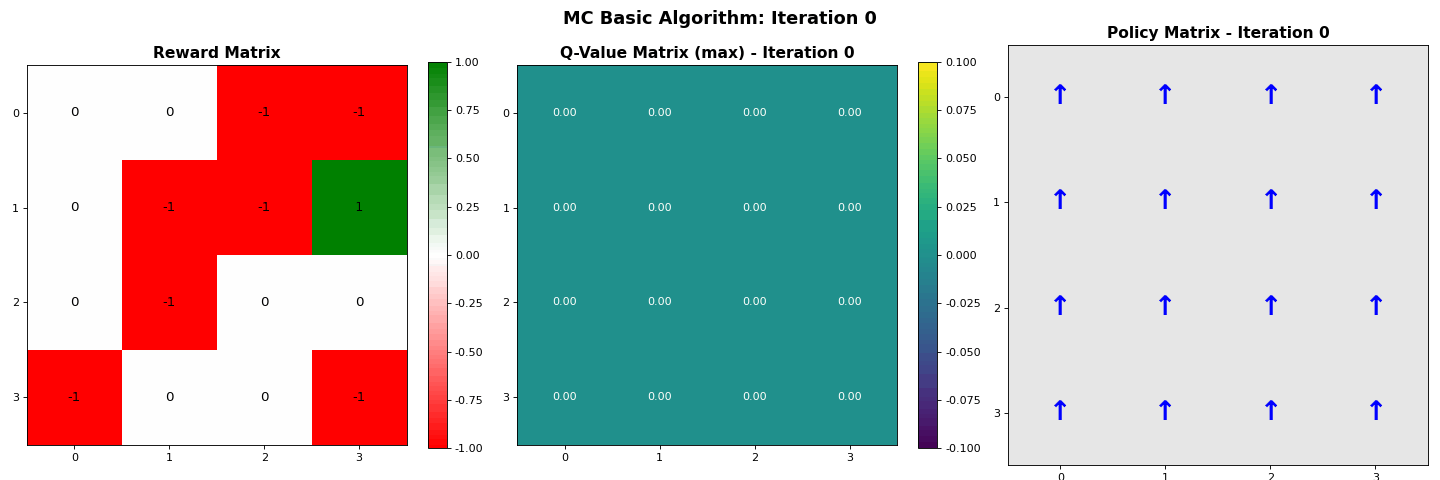

In [6]:
def run_mc_basic(
    gif_filename: Annotated[str, "输出 GIF 文件名"] = 'mc_basic.gif',
    fps: Annotated[int, "生成动画的帧率"] = 2,
) -> Annotated[Tuple[np.ndarray, np.ndarray, int], "最终 Q 值、策略以及迭代次数"]:
    """执行 MC Basic 算法并生成 GIF 动画"""
    print("=" * 70)
    print("🚀 MC Basic 算法启动".center(70))
    print("=" * 70)

    # 初始化
    num_states = GRID_SIZE * GRID_SIZE
    num_actions = 4

    # 初始化 Q 值和策略（均匀随机策略）
    Q = np.zeros((num_states, num_actions))
    policy = np.ones((num_states, num_actions)) / num_actions

    frames: List[np.ndarray] = []

    # 添加初始状态帧
    policy_arrows = get_policy_matrix(policy, GRID_SIZE)
    print(f"生成第 0 帧...")
    frames.append(render_mc_basic_to_array(env.rewards, Q, policy_arrows, 0))

    # MC Basic 主循环
    for iteration in range(1, MAX_ITERATIONS + 1):
        # 策略评估
        Q = mc_policy_evaluation(env, policy, Q, GAMMA, NUM_EPISODES)

        # 策略改进
        new_policy = greedy_policy_improvement(Q)

        # 检查策略是否改变
        policy_changed = not np.array_equal(policy, new_policy)
        policy = new_policy

        # 生成当前迭代的帧
        policy_arrows = get_policy_matrix(policy, GRID_SIZE)
        print(f"生成第 {iteration} 帧...")
        frames.append(render_mc_basic_to_array(env.rewards, Q, policy_arrows, iteration))

        if iteration <= 5:
            print(f"迭代 {iteration}: 策略{'已改变' if policy_changed else '未改变'}")

        # 如果策略不再改变，可以提前停止
        if not policy_changed and iteration > 3:
            print(f"策略在第 {iteration} 次迭代后收敛！")
            break

    print(f"{'=' * 70}")
    print("🎉 MC Basic 算法完成！".center(70))
    print(f"{'=' * 70}")
    print(f"✅ 总计迭代次数: {iteration}")

    # 在结尾多添加几帧以便观察最终结果
    for _ in range(5):
        frames.append(render_mc_basic_to_array(env.rewards, Q, policy_arrows, iteration))

    # 保存 GIF
    print(f"正在保存 GIF（共 {len(frames)} 帧）...")
    imageio.mimsave(gif_filename, frames, fps=fps, loop=0)

    print(f"✅ GIF 动画已保存: {gif_filename}")
    print(f"   - 总帧数: {len(frames)}")
    print(f"   - 帧率: {fps} fps")
    print(f"   - 迭代过程: 0 → {iteration}")

    return Q, policy, iteration

# 执行算法
Q_final, policy_final, num_iterations = run_mc_basic(
    gif_filename='mc_basic.gif',
    fps=2
)

# 显示 GIF
print(f"正在显示 GIF...")
display(IPImage(filename='mc_basic.gif'))



## 📚 总结与分析

### 🎯 你学到了什么

通过这个教程，你已经完整实现了 MC Basic 算法，并可视化了整个学习过程：

1. **蒙特卡洛估计的核心思想**
   - 通过采样回合来估计动作价值
   - 用平均回报近似期望回报
   - 无需环境模型，从经验中学习

2. **MC Basic 算法的工作原理**
   - 策略评估：从每个 (s,a) 采样多个回合，计算平均回报
   - 策略改进：根据 Q 值选择贪婪动作
   - 迭代收敛：重复评估-改进直到策略稳定

3. **无模型学习的特点**
   - 优点：不需要知道环境动态
   - 缺点：需要大量采样，样本效率较低
   - 适用场景：环境模型未知或难以获取

### 🔍 观察结果

从生成的 GIF 动画中，你可以观察到：

- **Q 值演化**：从初始的全零逐渐更新为接近真实值
- **策略改进**：策略逐渐指向高价值区域（目标状态）
- **收敛过程**：经过若干次迭代后策略不再变化

### 🎓 下一步学习

现在你已经掌握了 MC Basic，可以继续学习：

1. **MC ε-贪心算法**
   - 移除探索性起点的要求
   - 平衡探索与利用
   - 更实用的无模型学习方法

2. **时序差分学习（TD）**
   - 结合 MC 和动态规划的优点
   - 更高效的样本利用
   - Q-learning 和 SARSA 算法

3. **深度强化学习**
   - 使用神经网络近似 Q 函数
   - 处理大规模状态空间
   - DQN、A3C 等现代算法

---

**恭喜你完成了 MC Basic 算法的学习！** 🎉